In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
import torch.nn.functional as F
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
path2data = './data'
os.makedirs(path2data, exist_ok = True)

h, w = 64, 64
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

transform = transforms.Compose([
    transforms.Resize((h, w)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [9]:
train_ds = datasets.STL10(path2data, split = 'train', download = True, transform = transform)

Files already downloaded and verified


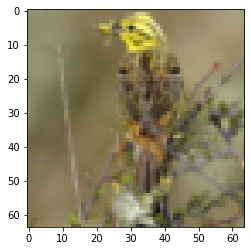

In [10]:
img, label = train_ds[0]
plt.imshow(to_pil_image(0.5*img + 0.5))

In [11]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size = 64, shuffle = True)

params = { 'nz' : 100,
           'ngf' : 64,
           'ndf' : 64,
           'img_channel' : 3
}

In [14]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        nz = params['nz']
        ngf = params['ngf']
        img_channel = params['img_channel']
        
        self.dconv1 = nn.ConvTranspose2d(nz, ngf* 8, 4, stride = 1, 
                                         padding = 0, bias = False)
        self.bn1 = nn.BatchNorm2d(ngf * 8)
        self.dconv2 = nn.ConvTranspose2d(ngf* 8, ngf* 4, 4, stride = 2,
                                        padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.dconv3 = nn.ConvTranspose2d(ngf*4 , ngf* 2, 4, stride = 2,
                                        padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(ngf * 2)
        self.dconv4 = nn.ConvTranspose2d(ngf*2, ngf, 4, stride = 2,
                                        padding = 1, bias = False)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.dconv5 = nn.ConvTranspose2d(ngf, img_channel, 4, stride = 2,
                                         padding = 1, bias = False)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.dconv1(x)))
        x = F.relu(self.bn2(self.dconv2(x)))
        x = F.relu(self.bn3(self.dconv3(x)))
        x = F.relu(self.bn4(self.dconv4(x)))
        x = torch.tanh(self.dconv5(x))
        return x
        

In [16]:
x = torch.randn(1, 100, 1, 1, device = device)
model_gen = Generator(params).to(device)
out = model_gen(x)
out.size()

torch.Size([1, 3, 64, 64])

In [17]:
from torchsummary import summary
summary(model_gen, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
   ConvTranspose2d-3            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-4            [-1, 256, 8, 8]             512
   ConvTranspose2d-5          [-1, 128, 16, 16]         524,288
       BatchNorm2d-6          [-1, 128, 16, 16]             256
   ConvTranspose2d-7           [-1, 64, 32, 32]         131,072
       BatchNorm2d-8           [-1, 64, 32, 32]             128
   ConvTranspose2d-9            [-1, 3, 64, 64]           3,072
Total params: 3,576,704
Trainable params: 3,576,704
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.97
Params size (MB): 13.64
Estimated Total Size (MB): 15.61
-------------------------------------

In [21]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()
        img_channel = params['img_channel']
        ndf = params['ndf']
        
        self.conv1 = nn.Conv2d(img_channel, ndf, 4, stride = 2,
                              padding = 1, bias = False)
        
        self.conv2 = nn.Conv2d(ndf, ndf*2, 4, stride = 2,
                               padding = 1, bias = False)
        
        self.bn2 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4 , 4, stride = 2, 
                               padding = 1, bias = False)
        
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf*4, ndf * 8, 4, stride = 2, 
                               padding = 1, bias = False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, stride = 1, padding = 0, bias = False)
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        return x.view(-1, 1)

x = torch.randn(16, 3, 64, 64, device = device)
model_dis = Discriminator(params).to(device)
output = model_dis(x)
output.size()

torch.Size([16, 1])

In [22]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [23]:
loss_func = nn.BCELoss()

from torch import optim
lr = 2e-4
beta = 0.5
beta2 = 0.999
opt_dis = optim.Adam(model_dis.parameters(), lr = lr, betas = (beta, beta2))
opt_gen = optim.Adam(model_gen.parameters(), lr = lr, betas = (beta, beta2))

In [25]:
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 100
start_time = time.time()
nz = params['nz']
loss_hit = {'dis' : [],
           'gen' : []}

for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.shape[0]
        xb, yb = xb.to(device), yb.to(device)
        yb_real = torch.Tensor(ba_si, 1).fill_(1.0).to(device)
        yb_fake = torch.Tensor(ba_si, 1).fill_(0.0).to(device)
        
        # Genrator 모델 학습하기
        model_gen.zero_grad()
        z = torch.randn(ba_si, nz, 1, 1).to(device)
        out_gen = model_gen(z)
        out_dis = model_dis(out_gen)
        
        g_loss = loss_func(out_dis, yb_real)
        g_loss.backward()
        opt_gen.step()
        
        # Discriminator 모델 학습하기
        model_dis.zero_grad()
        out_dis = model_dis(xb)
        loss_real = loss_func(out_dis, yb_real)
        
        out_dis = model_dis(out_gen.detach())
        loss_fake = loss_func(out_dis, yb_fake)
        
        d_loss = (loss_real + loss_fake) / 2
        d_loss.backward()
        opt_dis.step()
        
        loss_hit['gen'].append(g_loss.item())
        loss_hit['dis'].append(d_loss.item())

        batch_count += 1
        if batch_count % 100 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f' %(epoch, g_loss.item(), d_loss.item()))

Epoch: 1, G_Loss: 9.444139, D_Loss: 0.170360
Epoch: 2, G_Loss: 5.219487, D_Loss: 0.612655
Epoch: 3, G_Loss: 6.235883, D_Loss: 0.055497
Epoch: 5, G_Loss: 2.473818, D_Loss: 0.191411
Epoch: 6, G_Loss: 1.885285, D_Loss: 0.255603
Epoch: 7, G_Loss: 4.249115, D_Loss: 0.070901
Epoch: 8, G_Loss: 3.487085, D_Loss: 0.139259
Epoch: 10, G_Loss: 4.050807, D_Loss: 0.067251
Epoch: 11, G_Loss: 3.714221, D_Loss: 0.093108
Epoch: 12, G_Loss: 2.733478, D_Loss: 0.084316
Epoch: 13, G_Loss: 1.307740, D_Loss: 0.291369
Epoch: 15, G_Loss: 2.260891, D_Loss: 0.154781
Epoch: 16, G_Loss: 2.781301, D_Loss: 0.108037
Epoch: 17, G_Loss: 3.754194, D_Loss: 0.142568
Epoch: 18, G_Loss: 2.026821, D_Loss: 0.184015
Epoch: 20, G_Loss: 3.657382, D_Loss: 0.089252
Epoch: 21, G_Loss: 4.490862, D_Loss: 0.292376
Epoch: 22, G_Loss: 3.758162, D_Loss: 0.204947
Epoch: 24, G_Loss: 2.346884, D_Loss: 0.159619
Epoch: 25, G_Loss: 2.125675, D_Loss: 0.141687
Epoch: 26, G_Loss: 3.763019, D_Loss: 0.171117
Epoch: 27, G_Loss: 4.296917, D_Loss: 0.11

In [26]:
# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100,1,1, device=device)
    label = torch.randint(0,10,(16,), device=device)
    img_fake = model_gen(fixed_noise).detach().cpu()
print(img_fake.shape)

torch.Size([16, 3, 64, 64])


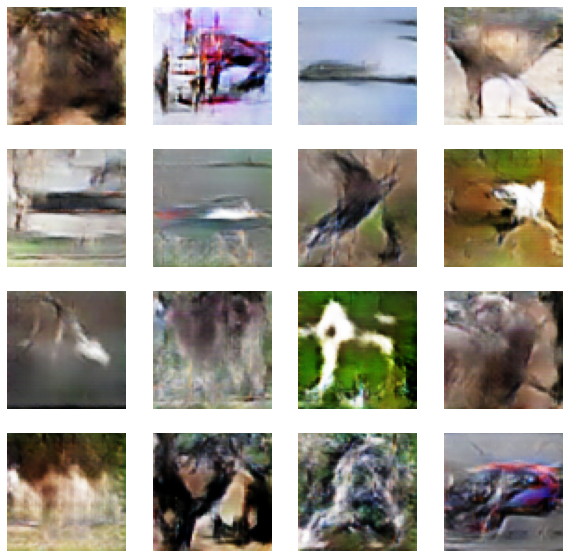

In [27]:
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5), cmap='gray')
    plt.axis('off')